<h1> Taxi Fare Prediction using Keras and Tensorflow Estimator </h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from dataset import *

import warnings
warnings.filterwarnings('ignore')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [2]:
# Parameters
TRAIN_PATH = 'tf_train.csv'
VALIDATION_PATH = 'tf_validation.csv'
TEST_PATH = 'test_processed.csv'
MODEL_DIR = 'model_1'
OUTPUT_NAME = 'output_keras.csv'

In [4]:
# Hyperparameters
LEARNING_RATE = 0.0001
STEPS = 200000
BATCH_SIZE = 512
DATASET_SIZE = 500000

In [5]:
CSV_COLUMNS = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
               'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night']
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [['nokey'], [1.0], ['2009-06-15 17:26:21 UTC'], [-74.0], [40.0], [-74.0], [40.7], [1.0], [2009], [6], [15],
            [17], [1], [1], [1]]

In [6]:
def process(df):
    df['pickup_longitude_binned'] = pd.qcut(df['pickup_longitude'], 16, labels=False)
    df['dropoff_longitude_binned'] = pd.qcut(df['dropoff_longitude'], 16, labels=False)
    df['pickup_latitude_binned'] = pd.qcut(df['pickup_latitude'], 16, labels=False)
    df['dropoff_latitude_binned'] = pd.qcut(df['dropoff_latitude'], 16, labels=False)

    df = df.drop('pickup_datetime', axis=1)

    return df

In [7]:
def process_test(df):
    #df = df.drop('pickup_datetime', axis=1)
    
    df['pickup_longitude_binned'] = pd.qcut(df['pickup_longitude'], 16, labels=False)
    df['dropoff_longitude_binned'] = pd.qcut(df['dropoff_longitude'], 16, labels=False)
    df['pickup_latitude_binned'] = pd.qcut(df['pickup_latitude'], 16, labels=False)
    df['dropoff_latitude_binned'] = pd.qcut(df['dropoff_latitude'], 16, labels=False)


    return df

In [8]:
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)

In [9]:
def add_relevant_distances(df):
    # Add airpot distances and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], df['pickup_latitude'], df['pickup_longitude'])
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], df['dropoff_latitude'], df['dropoff_longitude'])
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], df['pickup_latitude'], df['pickup_longitude'])
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], df['dropoff_latitude'], df['dropoff_longitude'])
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], df['pickup_latitude'], df['pickup_longitude'])
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], df['dropoff_latitude'], df['dropoff_longitude'])
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], df['pickup_latitude'], df['pickup_longitude'])
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], df['dropoff_latitude'], df['dropoff_longitude'])

    return df

In [10]:
def add_engineered(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']

    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    euclidean = (latdiff ** 2 + londiff ** 2) ** 0.5

    # Add new features
    df['latdiff'] = latdiff
    df['londiff'] = londiff
    df['euclidean'] = euclidean
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)

    # One-hot encoding columns
    # Note, this is note the best way to one-hot encode features, but probably the simplest and will work here
    df = pd.get_dummies(df, columns=['weekday'])
    df = pd.get_dummies(df, columns=['month'])

    return df

In [11]:
def input_function(features, labels=None, shuffle=False):
    input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
        x={"raw_input": features},
        y=labels,
        shuffle=shuffle
    )
    return input_fn

In [12]:
def read_dataset2(filename, mode, features_cols, label_col, default_value, batch_size=512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.io.decode_csv(records=value_column, record_defaults=default_value)
            features = dict(zip(features_cols, columns))
            label = features.pop(label_col)

            features = tf.cast(features, dtype=tf.float32)
            features = {"raw_input": add_engineered(features)}
            label = tf.cast(label, dtype=tf.float32)
            return features, label

        # Create list of file names that match "glob" pattern (i.e. data_file_*.csv)
        filenames_dataset = tf.data.Dataset.list_files(filename)
        # Read lines from text files
        # use tf.data.Dataset.flat_map to apply one to many transformations (here: filename -> text lines)
        textlines_dataset = filenames_dataset.flat_map(tf.data.TextLineDataset)
        # Parse text lines as comma-separated values (CSV)
        # use tf.data.Dataset.map      to apply one to one  transformations (here: text line -> feature list)
        dataset = textlines_dataset.map(decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None  # loop indefinitely
            dataset = dataset.shuffle(buffer_size=10 * batch_size)
        elif mode == tf.estimator.ModeKeys.EVAL:
            num_epochs = 1  # end-of-input after this
        else:
            num_epochs = 1  # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        batch_features, batch_labels = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()

        return batch_features, batch_labels

    return _input_fn


In [13]:
# Load values in a more compact form
dtype_train = {'key': 'str',
             'fare_amount': 'float32',
             'pickup_datetime': 'str',
             'pickup_longitude': 'float32',
             'pickup_latitude': 'float32',
             'dropoff_longitude': 'float32',
             'dropoff_latitude': 'float32',
             'passenger_count': 'uint8',
             'year': 'uint16',
             'month': 'uint8',
             'day': 'uint8',
             'hour': 'uint8',
             'weekday': 'uint8',
             'night': 'uint8',
             'late_night': 'uint8'}

dnames_train = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night']

dtype_test = {'key': 'str',
             'pickup_datetime': 'str',
             'pickup_longitude': 'float32',
             'pickup_latitude': 'float32',
             'dropoff_longitude': 'float32',
             'dropoff_latitude': 'float32',
             'passenger_count': 'uint8',
             'year': 'uint16',
             'month': 'uint8',
             'day': 'uint8',
             'hour': 'uint8',
             'weekday': 'uint8',
             'night': 'uint8',
             'late_night': 'uint8'}

dnames_test = ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night']

In [14]:
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE, names=dnames_train, dtype=dtype_train, usecols=[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14])
test = pd.read_csv(TEST_PATH, names=dnames_test, dtype=dtype_test, usecols=[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13])

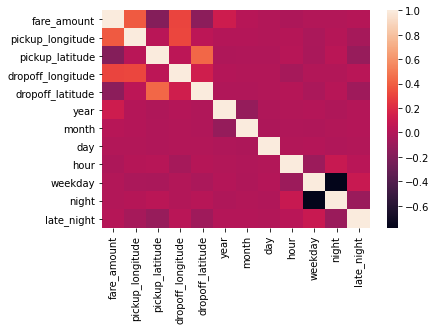

In [15]:
sns.heatmap(train.corr())
plt.show()

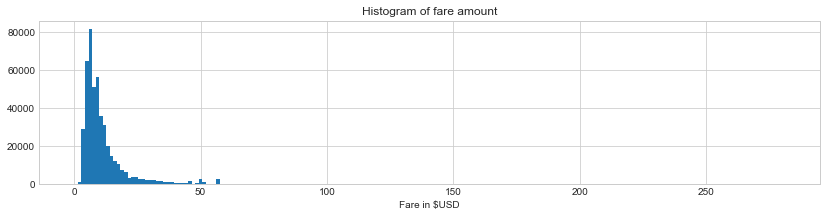

In [16]:
# matplotlib inline
plt.style.use('seaborn-whitegrid')

# Plot histogram of fare
train.fare_amount.hist(bins=200, figsize=(14,3))
plt.xlabel('Fare in $USD')
plt.title('Histogram of fare amount');

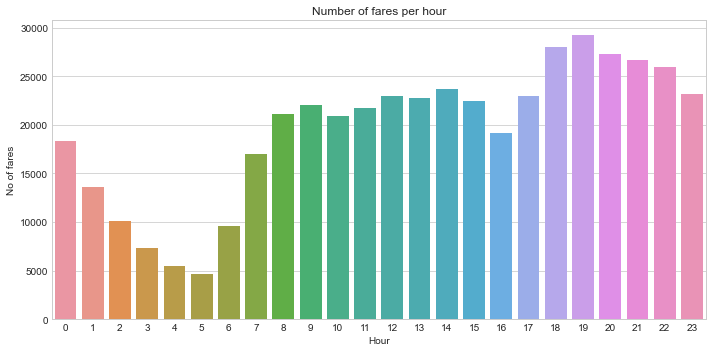

In [17]:
# Plot histogram of fares per hour
plt.figure(figsize = (10,5))
train_2 = train.groupby('hour', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'hour', ascending = True)
ax = sns.barplot(x=train_2.index, y=train_2['count'])
ax.set(xlabel='Hour', ylabel='No of fares')  
plt.title('Number of fares per hour')
plt.tight_layout()
plt.show()
del train_2

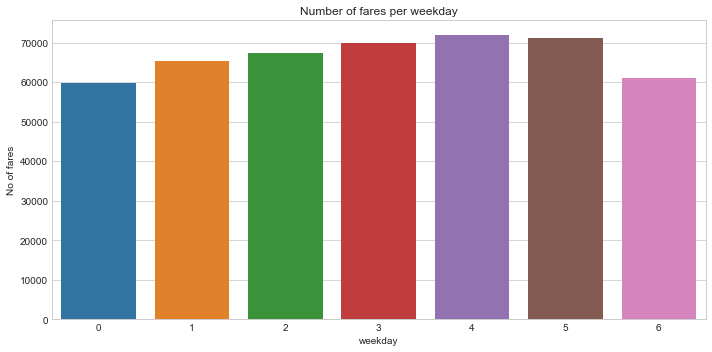

In [18]:
# Plot histogram of fares per weekday
plt.figure(figsize = (10,5))
train_3 = train.groupby('weekday', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=train_3.index, y=train_3['count'])
ax.set(xlabel='weekday', ylabel='No of fares')  
plt.title('Number of fares per weekday')
plt.tight_layout()
plt.show()
del train_3

In [19]:
# process data
train = process(train)
test = process(test)

train = add_relevant_distances(train)
test = add_relevant_distances(test)

train = add_engineered(train)
test = add_engineered(test)

# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude',
                   'dropoff_longitude', 'dropoff_latitude']
train_clean = train.drop(dropped_columns, axis=1)
test_clean = test.drop(dropped_columns + ['key'], axis=1)

In [20]:
# split data in train and validation (90% ~ 10%)
train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)

In [21]:
# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

In [22]:
# Scale data
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df).astype(np.float32)
validation_df_scaled = scaler.transform(validation_df).astype(np.float32)
test_scaled = scaler.transform(test_clean).astype(np.float32)

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, activation='relu', input_shape=(train_df_scaled.shape[1],), name='raw'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='linear', name='predictions'))

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
raw (Dense)                  (None, 512)               20992     
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [42]:
adam = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="mae", optimizer=adam, metrics=['mae', 'mse'])

In [43]:
run_config = tf.compat.v1.estimator.RunConfig(model_dir=MODEL_DIR, save_summary_steps=5000, save_checkpoints_steps=5000)
train_spec = tf.compat.v1.estimator.TrainSpec(input_fn=input_function(train_df_scaled, train_labels, True),
                                    max_steps=STEPS)
eval_spec = tf.compat.v1.estimator.EvalSpec(input_fn=input_function(validation_df_scaled, validation_labels, True),
                                  steps=1000, throttle_secs=300)

In [44]:
estimator = keras.estimator.model_to_estimator(keras_model=model, config=run_config)
tf.estimator.train_and_evaluate(estimator, train_spec=train_spec, eval_spec=eval_spec)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'model_1', '_tf_random_seed': None, '_save_summary_steps': 5000, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running trai

({'loss': 2.795886, 'mae': 2.795886, 'mse': 38.126583, 'global_step': 9840},
 [])

In [46]:
OUTPUT_NAME = 'sample_submission.csv'
prediction = estimator.predict(input_function(test_scaled))

prediction_df = pd.DataFrame(prediction)
output_submission(test, prediction_df, 'key', 'fare_amount', OUTPUT_NAME)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_1\model.ckpt-9840
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Output complete


In [47]:
def serving_input_fn():
    feature_placeholders = {
        'raw_input' : tf.compat.v1.placeholder(tf.float32, [1, 40, None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, 
                                                    feature_placeholders)

In [48]:
tf.compat.v1.disable_eager_execution()

In [49]:
estimator.export_saved_model('keras_estimator_savedmodel', serving_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from model_1\model.ckpt-9840
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras_estimator_savedmodel\temp-1622721938\saved_model.pb


b'keras_estimator_savedmodel\\1622721938'

In [50]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    ./keras_estimator_savedmodel/1622721938 \
    ./keras_estimator_savedmodel/json_model

Writing weight file ./keras_estimator_savedmodel/json_model\model.json...

2021-06-03 19:05:59.017240: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-03 19:05:59.018278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-03 19:06:41.183650: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-03 19:06:41.274746: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-06-03 19:06:42.417859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce 920M computeCapability: 3.5
coreClock: 0.954GHz coreCount: 2 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 13.41GiB/s
2021-06-03 19:06:42.424310: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynam


to_proto not supported in EAGER mode.
2021-06-03 19:06:45.363472: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-06-03 19:06:45.509498: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-06-03 19:06:45.518732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce 920M computeCapability: 3.5
coreClock: 0.954GHz coreCount: 2 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 13.41GiB/s
2021-06-03 19:06:45.638439: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-03 19:06:45.642217: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2021-06-03 19:06:45.645399: W tensorflow/stream_executor/platform/default/dso_l